In [2]:
from spectral_cube import SpectralCube #To read FITS
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from skimage import measure
from astropy import wcs
import cube_x3d as c3
import matplotlib.pyplot as plt
from matplotlib import cm
from astroquery.skyview import SkyView

In [66]:
import importlib
importlib.reload(c3)

<module 'cube_x3d' from 'c:\\Users\\ixaka\\Documents\\Visualization\\cube_x3d\\cube_x3d.py'>

In [5]:
%cd ~/Visualization

/home/ixakalabadie/Visualization


In [6]:
# Read the fits file and save header
HI_cube = SpectralCube.read("hcg90_HCG90_hcg90_line_masked.image.fits")
cubehead = HI_cube.header
cubew = wcs.WCS(cubehead)
nz, ny, nx = HI_cube.shape
print(HI_cube.shape)
dra, ddec, dv = cubehead['CDELT1'], cubehead['CDELT2'], cubehead['CDELT3']
delta_arcsec = (np.abs(dra)*3600, np.abs(ddec)*3600, np.abs(dv)/1e3) # to arcsec and GHz
print(delta_arcsec)

(802, 600, 600)
(10.00000000000008, 10.00000000000008, 26.122497000217002)


(array([5.03145411e-05, 1.67715137e-05, 6.70860547e-05, 1.67715137e-05,
        3.35430274e-05, 1.34170768e-04, 1.34172109e-04, 1.17400596e-04,
        3.01887246e-04, 2.85115733e-04, 2.68344219e-04, 4.69602383e-04,
        4.02516328e-04, 7.88261143e-04, 8.05032657e-04, 5.36688438e-04,
        1.03982345e-03, 1.22432050e-03, 1.57653017e-03, 1.84485728e-03,
        1.89518105e-03, 2.06289618e-03, 2.41509797e-03, 2.81761430e-03,
        2.93501489e-03, 3.57231456e-03, 4.36059356e-03, 4.12579237e-03,
        5.13208319e-03, 6.99372121e-03, 7.41297200e-03, 8.16772716e-03,
        9.64362037e-03, 1.18239171e-02, 1.30985522e-02, 1.49434187e-02,
        1.82976300e-02, 2.03941606e-02, 2.55262438e-02, 2.61971044e-02,
        2.96688077e-02, 3.38112026e-02, 3.72327604e-02, 4.27841314e-02,
        4.63900069e-02, 5.56311109e-02, 5.97401317e-02, 6.79746052e-02,
        7.74173072e-02, 8.47632302e-02, 9.60001443e-02, 1.04486530e-01,
        1.21978609e-01, 1.32847160e-01, 1.44134389e-01, 1.578031

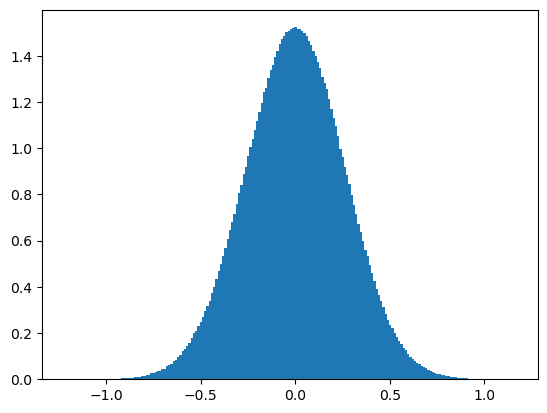

In [7]:
plt.hist(HI_cube.unmasked_data[:20].to_value().flatten()*1000, bins=200, density=True);

In [8]:
# calculate rms of data. choose an area with no emission
from scipy.stats import norm
_, rms = norm.fit(HI_cube.unmasked_data[:20].to_value().flatten()*1000)

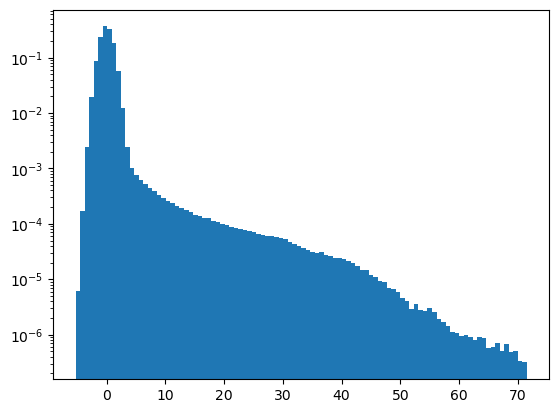

In [12]:
plt.hist(HI_cube.unmasked_data[:].to_value().flatten(), bins=100, density=True)
plt.yscale('log')
plt.xlim(0,)
plt.axvline(3)

In [21]:
#define isoleves in mJy/beam
#isolevels = np.array([1.5, 2.5, 3.5, 6]) #hcg91
#isolevels = np.array([1.5, 4.5, 8.5, 13]) #hcg16
#isolevels = np.array([1.5, 3.5, 6.5, 11]) #hcg31
isolevels = np.array([3, 8, 13, 17, 21]) #hcg90 *1000

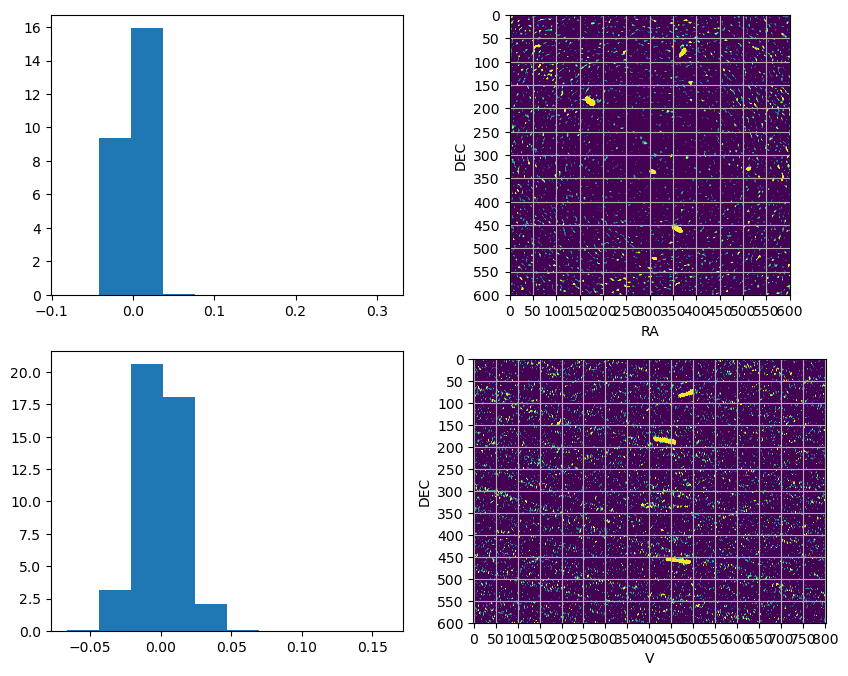

In [36]:
c3.preview2d(HI_cube.unmasked_data[:].to_value(), vmin1=0.008, vmax1=0.02, vmin2=0.008, vmax2=0.02, norm='asinh')

In [ ]:
limx = [0, nx-1]
limy = [0, ny-1]
limz = [0, nz-1]

In [13]:
#HCG31
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [60, nx-61]
limy = [100, ny-91]
limz = [90, nz-81]

In [ ]:
#HCG16
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [80, nx-16]
limy = [50, ny-11]
limz = [0, nz-1]

In [ ]:
#HCG91
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [100, nx-101]
limy = [100, ny-81]
limz = [10, nz-11]

In [74]:
#HCG90
# Limits to crop the cube, no HI there. Subtract 1 to wanted number, e.g. nz-1.
limx = [100, nx-1]
limy = [0, ny-101]
limz = [300, nz-201]

In [75]:
ralim = HI_cube.spatial_coordinate_map[1][0,:][limx][::int(np.sign(cubehead["CDELT1"]))]
ramean = np.mean(ralim)
declim = HI_cube.spatial_coordinate_map[0][:,0][limy][::int(np.sign(cubehead["CDELT2"]))]
decmean = np.mean(declim)
vlim = HI_cube.spectral_axis[limz][::int(np.sign(dv))]
vmean = np.mean(vlim).to('kHz').to_value()

In [76]:
def transpose(array, delta):
    dra, ddec, dv = delta
    return np.transpose(array, (2,1,0))[::int(np.sign(dra)), ::int(np.sign(ddec)),::int(np.sign(dv))]

In [77]:
# create cropped array and transform units to mJy/beam
HI_cube = HI_cube.unmasked_data[limz[0]:limz[1]+1,limy[0]:limy[1]+1,limx[0]:limx[1]+1].to(u.mJy/u.beam).to_value()
# Slice the data, transpose to (ra,dec,v) and flip axes if needed (see if step in FITS header is + or -)
HI_cube = transpose(HI_cube, (dra,ddec,dv))

In [78]:
# Save new dimensions
nx_2, ny_2, nz_2 = HI_cube.shape
print(HI_cube.shape)

(500, 500, 302)


In [18]:
c = '0 0 1'
# HCG31 all from LVM et al. (2005)
gals = {'HCG31a':{'v':4090,'col':c},
       'HCG31b':{'v':4122,'col':c},
       'HCG31c':{'v':3984,'col':c},
        'HCG31g':{'v':4005,'col':c},
        'HCG31q':{'v':4090,'col':c}
       }

In [1]:
c = '0 0 1'
# HCG16 from Hickson 1992
gals = {'HCG16a':{'v':4152,'col':c},
       'HCG16b':{'v':3977,'col':c},
       'HCG16c':{'v':3851,'col':c},
        'HCG16d':{'v':3847,'col':c},
        'NGC848':{'v':4001, 'col':c}
       }

In [ ]:
c = '0 0 1'
# HCG91 from Hickson 1992
gals = {'HCG91a':{'v':6832,'col':c},
       'HCG91b':{'v':7196,'col':c},
       'HCG91c':{'v':7319,'col':c},
        'HCG91d':{'v':7195,'col':c}
       }

In [ ]:
for (k,gal) in enumerate(gals.keys()):

    # Go from RA/Dec -> rescaled pixel space !
    coords = SkyCoord.from_name(gal)
    #coords = SkyCoord(gals[gal]['ra'], gals[gal]['dec'])
    #pixcrd = coords.to_pixel(w,1)
    
    coords.ra.deg = (coords.ra.deg-ramean.to_value())*np.cos(np.radians(declim[0]))*3600
    coords.dec.deg = (coords.dec.deg-decmean.to_value())*3600.

    gals[gal]['coord'] = np.array([coords.ra.deg, coords.dec.deg, gals[gal]['v']-vmean])

In [79]:
coords = np.array([ralim, declim, vlim])

In [80]:
color = c3.create_colormap('CMRmap', isolevels)

NameError: name 'isolevels' is not defined

In [81]:
meta = {'generator':'create_x3d python module',
       'creator':'Name Surname',
       'title':cubehead['OBJECT'],
        'numberofelements':f'{len(isolevels)} layers', 
        'description':'HI data cube of %s'%cubehead['OBJECT']
       } #{len(gals)} galaxies',

In [93]:
x3dname = 'HCG90_test0.x3d'

In [94]:
file = c3.write_x3d('./cube_x3d/examples/%s'%x3dname, delta_arcsec, header=cubehead,
                    coords=coords, units=['mJy/beam', 'arcsec', 'arcsec', 'kHz'],
                     meta=meta, picking=False)

#also need html.func_pick() if picking=True

[[-2495.12056686     0.          2495.12056686]
 [-2494.96440292     0.          2494.96440292]
 [-3931.43579853     0.          3931.43579853]]


In [69]:
survey = ['DSS2 Blue']
verts = (coords[0,0], coords[0,1], coords[1,0], coords[1,1])
imcol, img_shape, img = c3.get_imcol(position='HCG90', survey=survey, verts=verts,
                                     unit='deg', pixels='6500,6500',
                         coordinates='J2000',grid=True, gridlabels=True)

In [71]:
np.max(HI_cube)

2.4665775e-05

In [95]:
file.make_layers(HI_cube, isolevels, [color])
file.make_outline()
#file.make_galaxies(gals=gals, labels=True)
file.make_image2d(imcol=None, img_shape=None)
file.make_ticklines()
file.make_animation()
file.make_labels(gals=None, axlab='both') 
# html.func_scalev(axes) should be same as axlab, not func_axes() though.
file.close()

In [88]:
cubehead

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3                                                  
NAXIS1  =                  600                                                  
NAXIS2  =                  600                                                  
NAXIS3  =                  802                                                  
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BUNIT   = 'beam-1 Jy'          / Units are in Jansky per beam                   
BMAJ    =   0.0127168696855735                                                  
BMIN    =   0.0123870549038629                                                  
BPA     =     166.817441495812                                                  
BTYPE   = 'Intensity'       

In [96]:
tabtitle = 'HCG90'
pagetitle = 'HCG90 interactive HI datacube with X3D'
# add in desc for 2d image: <br>\n\t Background image: {survey}
#desc = f"Object: {cubehead['OBJECT']}.<t> Telescope: {cubehead['TELESCOP']}. RestFreq = {cubehead['RESTFREQ']/1e6:.4f} MHz.<br>\n\t Center: (RA,Dec,V)=({np.round(ramean,5)}, {np.round(decmean,5)}, {np.round(vmean,3)} km/s)"

In [97]:
colmaps = ['magma', 'CMRmap', 'inferno', 'plasma', 'viridis', 'Greys',
           'Blues', 'OrRd', 'PuRd', 'Reds', 'Spectral', 'Wistia',
          'YlGn', 'YlOrRd', 'afmhot', 'autumn', 'cool', 'coolwarm',
          'copper', 'cubehelix', 'flag', 'gist_earth', 'gist_heat',
          'gist_ncar', 'gist_stern', 'gnuplot', 'gnuplot2', 'hot',
          'nipy_spectral', 'prism', 'winter', 'Paired']

In [98]:
html = c3.write_html('./cube_x3d/examples/%s.html'%x3dname.split('.')[0], units=['mJy/beam', 'arcsec', 'arcsec', 'kHz'],
                     tabtitle=tabtitle, pagetitle=pagetitle,
                     description=None)

In [99]:
html.func_layers(isolevels)
#html.func_galaxies(gals)
#html.func_gallab()
html.func_grids()
html.func_axes('both')
#html.func_pick() #for coordinate picking
html.func_animation()
html.start_x3d()
html.viewpoints(file.diff_coords[:,2])
html.close_x3d(x3dname)
html.buttons([isolevels], [color], colormaps=colmaps, hide2d=True, scalev=True, move2d=True)
#func_move2dimage, func_colormaps and func_scalev must always go after buttons
html.func_image2d()
html.func_colormaps([isolevels])
html.func_scalev(gals=None, axes='both', coords=file.diff_coords)
html.func_move2dimage(file.diff_coords[2,2], file.real_coords[2,2])
html.close_html()